In [ ]:
# расскоментируйте код ниже, чтобы установить все зависимости
!pip install tensorboard==2.13.0 \
    tensorflow==2.13.0 \
    pyarrow==12.0.1 \
    polars==0.18.6 \
    tqdm==4.65.0 \
    scipy==1.11.1 \
    scikit-learn==1.3.0 \
    numpy==1.24.3 \
    Pillow==10.0.0

In [2]:
import os
import pandas as pd
import numpy as np
import polars as pl
from tqdm import tqdm

from typing import List

import numpy as np
import scipy.sparse as sp
from sklearn.preprocessing import normalize

from PIL import Image
import requests
import matplotlib.pyplot as plt

# import tensorflow as tf
# from tensorboard.plugins import projector
# from sentence_transformers import SentenceTransformer
# from transformers import AutoTokenizer, AutoModel, BertModel, BertTokenizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import numpy as np
import re
from functools import partial

movies_df = pl.from_pandas(pd.read_parquet('imdb_movies.parquet'))
movies_df

title_id,poster_url,type,name,original_name,description,genre,date,rating_count,rating_value,keywords,featured_review,stars,directors,creators
str,str,str,str,str,str,list[str],str,f64,f64,list[str],str,list[str],list[str],list[str]
"""tt0111161""","""https://m.medi…","""Movie""","""Побег из Шоуше…","""The Shawshank …","""Over the cours…","[""Drama""]","""1994-10-14""",2.755277e6,9.3,"[""prison"", ""based on the works of stephen king"", … ""voice over narration""]","""It is no wonde…","[""Tim Robbins"", ""Morgan Freeman"", ""Bob Gunton""]","[""Frank Darabont""]","[""Stephen King"", ""Frank Darabont""]"
"""tt0068646""","""https://m.medi…","""Movie""","""Крестный отец""","""The Godfather""","""Don Vito Corle…","[""Crime"", ""Drama""]","""1972-03-24""",1.917037e6,9.2,"[""mafia"", ""patriarch"", … ""rise to power""]","""I love this mo…","[""Marlon Brando"", ""Al Pacino"", ""James Caan""]","[""Francis Ford Coppola""]","[""Mario Puzo"", ""Francis Ford Coppola""]"
"""tt0468569""","""https://m.medi…","""Movie""","""Тёмный рыцарь""","""The Dark Knigh…","""When the menac…","[""Action"", ""Crime"", ""Drama""]","""2008-08-14""",2.728169e6,9.0,"[""dc comics"", ""psychopath"", … ""clown""]","""If someone els…","[""Christian Bale"", ""Heath Ledger"", ""Aaron Eckhart""]","[""Christopher Nolan""]","[""Jonathan Nolan"", ""Christopher Nolan"", ""David S. Goyer""]"
"""tt0050083""","""https://m.medi…","""Movie""","""12 разгневанны…","""12 Angry Men""","""The jury in a …","[""Crime"", ""Drama""]","""1961-11-13""",816234.0,9.0,"[""jury"", ""dialogue driven"", … ""jury room""]","""&apos;12 Angry…","[""Henry Fonda"", ""Lee J. Cobb"", ""Martin Balsam""]","[""Sidney Lumet""]","[""Reginald Rose""]"
"""tt0071562""","""https://m.medi…","""Movie""","""Крестный отец …","""The Godfather …","""The early life…","[""Crime"", ""Drama""]","""1974-12-18""",1.305122e6,9.0,"[""revenge"", ""1950s"", … ""lake tahoe nevada""]","""The original G…","[""Al Pacino"", ""Robert De Niro"", ""Robert Duvall""]","[""Francis Ford Coppola""]","[""Francis Ford Coppola"", ""Mario Puzo""]"
"""tt0108052""","""https://m.medi…","""Movie""","""Список Шиндлер…","""Schindler&apos…","""In German-occu…","[""Biography"", ""Drama"", ""History""]","""1994-05-21""",1.388917e6,9.0,"[""holocaust"", ""nazi"", … ""german""]","""This Movie was…","[""Liam Neeson"", ""Ralph Fiennes"", ""Ben Kingsley""]","[""Steven Spielberg""]","[""Thomas Keneally"", ""Steven Zaillian""]"
"""tt0167260""","""https://m.medi…","""Movie""","""Властелин коле…","""The Lord of th…","""Gandalf and Ar…","[""Action"", ""Adventure"", ""Drama""]","""2004-01-22""",1.892435e6,9.0,"[""journey"", ""orc"", … ""ring""]","""Wonderful on e…","[""Elijah Wood"", ""Viggo Mortensen"", ""Ian McKellen""]","[""Peter Jackson""]","[""J.R.R. Tolkien"", ""Fran Walsh"", ""Philippa Boyens""]"
"""tt0110912""","""https://m.medi…","""Movie""","""Криминальное ч…","""Pulp Fiction""","""The lives of t…","[""Crime"", ""Drama""]","""1995-09-29""",2.115956e6,8.9,"[""nonlinear timeline"", ""overdose"", … ""drug dealing""]","""I can only spe…","[""John Travolta"", ""Uma Thurman"", ""Samuel L. Jackson""]","[""Quentin Tarantino""]","[""Quentin Tarantino"", ""Roger Avary""]"
"""tt0120737""","""https://m.medi…","""Movie""","""Властелин коле…","""The Lord of th…","""A meek Hobbit …","[""Action"", ""Adventure"", ""Drama""]","""2002-03-01""",1.920951e6,8.8,"[""ring"", ""quest"", … ""elf""]","""Here is one fi…","[""Elijah Wood"", ""Ian McKellen"", ""Orlando Bloom""]","[""Peter Jackson""]","[""J.R.R. Tolkien"", ""Fran Walsh"", ""Philippa Boyens""]"


In [2]:
movies_df['type'].value_counts()

type,counts
str,u32
"""Movie""",8355
"""TVSeries""",1443


In [3]:
movies_df = movies_df.with_columns(
    # далее будем работать с признаками как со списком значений
    pl.col("type").apply(lambda x: [x]).alias("type"),
    # создадим колонку date_years_4, которая содержит диапазон лет, по которым мы будем искать похожие тайтлы
    pl.col("date")
    .apply(lambda x: [str(v) for v in range(int(x[:4]) - 4, int(x[:4]) + 4 + 1)])
    .alias("date_years_4"),
)

## Описание данных

Для решения задачи вам доступны следующие данные из файла `imdb_movies.parquet`

| Поле            | Тип                  | Описание                                 |
|---              |---                   |---                                       |
| title_id        | str                  | IMDb идентификатор                       |
| poster_url      | str                  | Ссылка на постер                         |
| type            | str                  | Тип тайтла: Movie или TVSeries           |
| name            | str                  | Название тайтла на русском               |
| original_name   | str                  | Оригинальное название тайтла             |
| description     | str                  | Описание тайтла с IMDb                   |
| genre           | list[str]            | Список жанров                            |
| date            | str                  | Дата выпуска тайтла                      |
| rating_count    | int                  | Количество отзывов для тайтла            |
| rating_value    | float                | Средний рейтинг тайтла                   |
| keywords        | list[str]            | Ключевые слова для тайтла (сгенерированы пользователями IMDb) |
| featured_review | str                  | Избранная рецензия для тайтла            |
| stars           | list[str]            | Список ключевых актеров                  |
| directors       | list[str]            | Список режиссеров                        |
| creators        | list[str]            | Список создателей                        |

## Оценивание

В качестве метрики качества используется hitrate@10, которую можно интерпретировать как **вероятность, что хотя бы один из топ-10 рекомендуемых объектов является релевантным**. Чтобы получить максимальный балл, достаточно добиться hitrate@10 = 0.3

В качестве `y_relevant` используются тайтлы, которые встречаются вместе в оценках пользователей

In [4]:
TOP_K = 10
SUBMISSION_PATH = 'submission.parquet'
RELEVANT_TITLES_PATH = 'relevant_titles_subsample.parquet'


def hitrate(y_relevant: List[str], y_preds: List[str], k: int = TOP_K) -> int:
    return int(len(set(y_relevant).intersection(y_preds[:k])) > 0)

# код для подсчета метрики качества
def print_score():
    hitrate_list = []
    user_preds = {title_id: recs for title_id, recs in pl.read_parquet(SUBMISSION_PATH).rows()}
    for title_id, relevant_items in pl.read_parquet(RELEVANT_TITLES_PATH).rows():
        recommended_titles = user_preds.get(title_id, [])[:TOP_K]
        hitrate_list.append(hitrate(relevant_items, recommended_titles))

    mean_hitrate = float(np.mean(hitrate_list))
    print(f'HITRATE@10 = {mean_hitrate}')

## Построим случайные рекомендации

In [5]:
def get_recommendations(seed_title_id: str, k: int = TOP_K) -> List[str]:
    # берем с запасом, чтобы не рекомендовать тайтл для самого себя
    random_movies = np.random.choice(movies_df['title_id'].unique().to_list(), TOP_K + 1)
    return [title_id for title_id in random_movies if title_id != seed_title_id][:k]

submission = []
for item_ind in tqdm(range(len(movies_df))):
    title_id = movies_df['title_id'][item_ind]
    recommended_titles = get_recommendations(title_id, TOP_K)
    submission.append((title_id, recommended_titles))
pl.DataFrame(submission, schema=('title_id', 'recs')).write_parquet('submission.parquet')

print_score()

100%|██████████| 9798/9798 [00:27<00:00, 353.56it/s]


HITRATE@10 = 0.032


## Построим рекомендации самых популярных

In [6]:
# берем с запасом, чтобы не рекомендовать тайтл для самого себя
top_movies = movies_df.sort('rating_value', descending=True)['title_id'][:(TOP_K + 1)].to_list()

def get_recommendations(seed_title_id: str, k: int = TOP_K) -> List[str]:
    return [title_id for title_id in top_movies if title_id != seed_title_id][:k]

submission = []
for item_ind in tqdm(range(len(movies_df))):
    title_id = movies_df['title_id'][item_ind]
    recommended_titles = get_recommendations(title_id, TOP_K)
    submission.append((title_id, recommended_titles))
pl.DataFrame(submission, schema=('title_id', 'recs')).write_parquet('submission.parquet')

print_score()

100%|██████████| 9798/9798 [00:00<00:00, 178335.41it/s]

HITRATE@10 = 0.08


## Формат разреженных матриц

In [6]:
row = np.array([0, 0, 0, 1, 2, 2, 2])
col = np.array([0, 0, 2, 2, 0, 1, 2])
data = np.array([1, 1, 2, 3, 4, 5, 6])
sp.csr_matrix((data, (row, col)), shape=(3, 3)).toarray()

array([[2, 0, 2],
       [0, 0, 3],
       [4, 5, 6]])

## Построим рекомендации на основе пересечения ключевых слов для категориальных признаков

In [7]:
sim_dict = {}
feature_columns = [
    "date_years_4",
    "type",
    "keywords",
    "genre",
    "directors",
    "creators",
    "stars",
]

for col in tqdm(feature_columns):
    # закодируем категориальные признаки
    mapping = {k: v for v, k in enumerate(movies_df[col].explode().unique().to_list())}

    # построим разреженную матрицу признаков для каждого тайтла
    rows = []
    cols = []
    values = []
    for row_ind, value in enumerate(movies_df[col]):
        value = [] if value is None else value

        # колонки – значения признака
        col_inds = [mapping[x] for x in value]
        rows.extend([row_ind] * len(col_inds))
        # ставим 1, если такой признак относится к тайтлу
        values.extend([1] * len(col_inds))
        cols.extend(col_inds)

    # построим матрицу похожести для каждого признака с помощью матрики косинусного расстояния
    sparse_data = sp.csr_matrix((values, (rows, cols)))
    sparse_data = normalize(sparse_data, norm="l2", axis=1)
    sim_dict[col] = (sparse_data @ sparse_data.T).A

100%|██████████| 7/7 [00:16<00:00,  2.41s/it]


In [9]:
def get_recommendations(title_ind: int, k: int = 10):
    nearest_inds = np.argsort(sim_dict['keywords'][title_ind])[::-1][:k]
    return movies_df[nearest_inds]['title_id'].to_list()

TOP_K = 10

submission = []
for title_ind in tqdm(range(len(movies_df))):
    title_id = movies_df['title_id'][title_ind]
    recommended_titles = get_recommendations(title_ind, TOP_K)
    submission.append((title_id, recommended_titles))

submission = pl.DataFrame(submission, schema=('title_id', 'recs'))
submission.write_parquet('submission.parquet')
display(submission.head())

print_score()

100%|██████████| 9798/9798 [00:10<00:00, 936.91it/s] 


title_id,recs
str,list[str]
"""tt0111161""","[""tt0111161"", ""tt7667038"", … ""tt12482898""]"
"""tt0068646""","[""tt0068646"", ""tt11497716"", … ""tt0158493""]"
"""tt0468569""","[""tt0468569"", ""tt7302054"", … ""tt0078346""]"
"""tt0050083""","[""tt0050083"", ""tt7949212"", … ""tt0338616""]"
"""tt0071562""","[""tt0071562"", ""tt4882708"", … ""tt0079501""]"


HITRATE@10 = 0.096


In [16]:
type(sim_dict['keywords'])

numpy.ndarray

## Сохраним эмбеддинги для просмотра в tensorboard

In [30]:
!rm -rf ./embs

In [35]:
log_dir = './embs'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

with open(os.path.join(log_dir, 'metadata.tsv'), "w") as f:
    for title_name in movies_df[:1_000]['name']:
        f.write(f'{title_name}\n')

weights = tf.Variable(sparse_data[:1_000].A)
checkpoint = tf.train.Checkpoint(embedding=weights)
checkpoint.save(os.path.join(log_dir, "embedding.ckpt"))

config = projector.ProjectorConfig()
embedding = config.embeddings.add()
embedding.tensor_name = "embedding/.ATTRIBUTES/VARIABLE_VALUE"
embedding.metadata_path = 'metadata.tsv'
projector.visualize_embeddings(log_dir, config)

In [36]:
!tensorboard --logdir embs --bind_all

2024-07-24 14:51:56.966393: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-24 14:51:57.025263: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-07-24 14:51:57.026017: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-24 14:51:57.862726: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/opt/conda/lib/python3.8/site-packages/tensorboard_data_server/bin/server: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.33' not found (required by /opt/conda/lib/python3.8/site-packages/tensorboard_data_server/bin/server)
/opt/conda/lib/python3.8/site-packages/tensorboard_data_s

## Визуализация рекомендаций

In [25]:
def get_recommendations_inds(sims: np.ndarray, item_ind: int, k: int = 10):
    nearest_inds = np.argsort(sims[item_ind])[::-1][:k]
    return nearest_inds

In [47]:
def plot_recs(title_id = 'tt0121766', rec_func=get_recommendations_inds, sims=sim_dict['keywords']):
    k = 5
    fig, axs = plt.subplots(1, k + 1, figsize=(25, 10))
    title_ind = movies_df['title_id'].to_list().index(title_id)
    relevant_titles = (
        pl.read_parquet(RELEVANT_TITLES_PATH)
        .filter(pl.col('title_id') == title_id)
    )['relevant_titles'].explode().to_list()
    
    # отрисовываем запрашиваемый тайтл
    url = movies_df['poster_url'][title_ind]
    im = Image.open(requests.get(url, stream=True).raw)
    axs[0].imshow(im)
    axs[0].axis('off')
    axs[0].set_title(movies_df['name'][title_ind])
    
    # строим рекомендации
    print(title_ind)
    nearest_inds = get_recommendations_inds(sims, title_ind, k)
    recs_posters = movies_df[nearest_inds]['poster_url']
    recs_names = movies_df[nearest_inds]['name']
    recs_title_ids = movies_df[nearest_inds]['title_id']
    
    # визуализируем рекомендации
    for i, (url, name) in enumerate(zip(recs_posters, recs_names)):
        im = Image.open(requests.get(url, stream=True).raw)
        axs[1 + i].imshow(im)
        axs[1 + i].axis('off')
        axs[1 + i].set_title(name, color=('g' if recs_title_ids[i] in relevant_titles else 'r'))
    
    plt.show();

1434


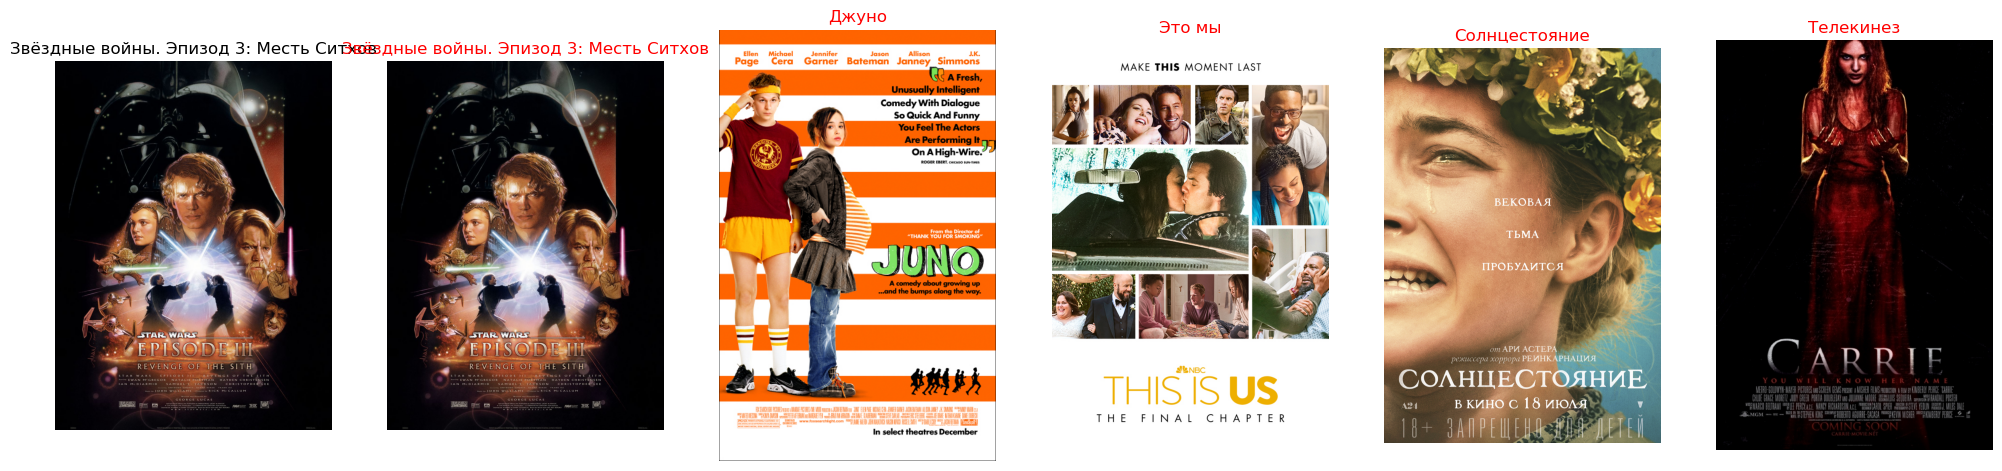

In [48]:
plot_recs(title_id = 'tt0121766', rec_func=get_recommendations_inds,, sims=sim_dict['keywords'])

Идеи для улучшения:
- попробуйте различные метрики дистанции между эмбеддингами
- используйте больше признаков для построения разреженной матрицы
- попробуйте использовать description и featured_review для извлечения признаков (например, tf-idf/w2v/openAI эмбеддинги)

In [49]:
class TextTransformer:
    def __init__(
        self,
        lowercase=True,
        preprocessor=None,
        pattern="[a-zа-я]+",
        min_word_length=2,
        stop_words=None,
        drop_duplicates=False,
    ):
        self.lowercase = lowercase
        self.preprocessor = preprocessor
        self.pattern = pattern
        self._tokenizer = re.compile(self.pattern).findall
        self.min_word_length = min_word_length
        self.stop_words = stop_words or []
        self.drop_duplicates = drop_duplicates

    def __call__(self, text):
        return self.transform_text(text)

    def transform_text(self, text):
        if self.lowercase:
            text = text.lower()
        if self.preprocessor:
            text = self.preprocessor(text)
        text = self._tokenizer(text)
        text = [
            word
            for word in text
            if len(word) >= self.min_word_length and word not in self.stop_words
        ]
        if self.drop_duplicates:
            unique_text = []
            for word in text:
                if word not in unique_text:
                    unique_text.append(word)
            text = [*unique_text]
        return " ".join(text)

In [50]:
movies_df_df = movies_df.to_pandas()
for col_nm in ['genre', 'keywords', 'stars', 'directors', 'creators']:
    movies_df_df[col_nm] = movies_df_df[col_nm].apply(lambda x: ' '.join(x) if x is not None else '').str.replace('"', '')
movies_df_df['text_descr'] = movies_df_df.loc[:, [ 'description','featured_review', 'original_name']].fillna('').apply(lambda x: '.'.join(x.unique()), axis=1)
trans = TextTransformer()
movies_df_df['text_descr']  = movies_df_df['text_descr'].apply(trans)

In [51]:
model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2", device='cuda')
embeddings = model.encode(movies_df_df.text_descr.to_list(), show_progress_bar=True)
sim_dict['embs'] = cosine_similarity(embeddings)

Batches:   0%|          | 0/307 [00:00<?, ?it/s]

In [52]:
sims = np.zeros((len(movies_df),len(movies_df)))
for k,v in sim_dict.items():
    sims+=v-np.eye(len(movies_df))
    

In [53]:
N = len(movies_df)

similarities = np.zeros((N, N))
for k, v in tqdm(sim_dict.items()):
    weight = 1  # каждый признак имеет одинаковую важность
    # итоговая похожесть -- усреднение похожести по каждому признаку
    similarities += weight * (v - np.eye(N))  # вычитаем 

100%|██████████| 8/8 [00:15<00:00,  1.97s/it]


In [54]:
def get_recommendations(item_ind: int, k: int = 10):
    nearest_inds = np.argsort(similarities[item_ind])[::-1][:k]
    return movies_df[nearest_inds]['title_id'].to_list()

In [55]:
TOP_K = 10

submission = []
for title_ind in tqdm(range(len(movies_df))):
    title_id = movies_df['title_id'][title_ind]
    recommended_titles = get_recommendations(title_ind, TOP_K)
    submission.append((title_id, recommended_titles))

submission = pl.DataFrame(submission, schema=('title_id', 'recs'))
submission.write_parquet('submission.parquet')
display(submission.head())

print_score()

100%|██████████| 9798/9798 [00:15<00:00, 644.71it/s]


title_id,recs
str,list[str]
"""tt0111161""","[""tt0120689"", ""tt0100157"", … ""tt0286942""]"
"""tt0068646""","[""tt0071562"", ""tt0099674"", … ""tt0070643""]"
"""tt0468569""","[""tt0372784"", ""tt1345836"", … ""tt1197624""]"
"""tt0050083""","[""tt0118528"", ""tt0051201"", … ""tt0072890""]"
"""tt0071562""","[""tt0068646"", ""tt0099674"", … ""tt0086066""]"


HITRATE@10 = 0.338


1434


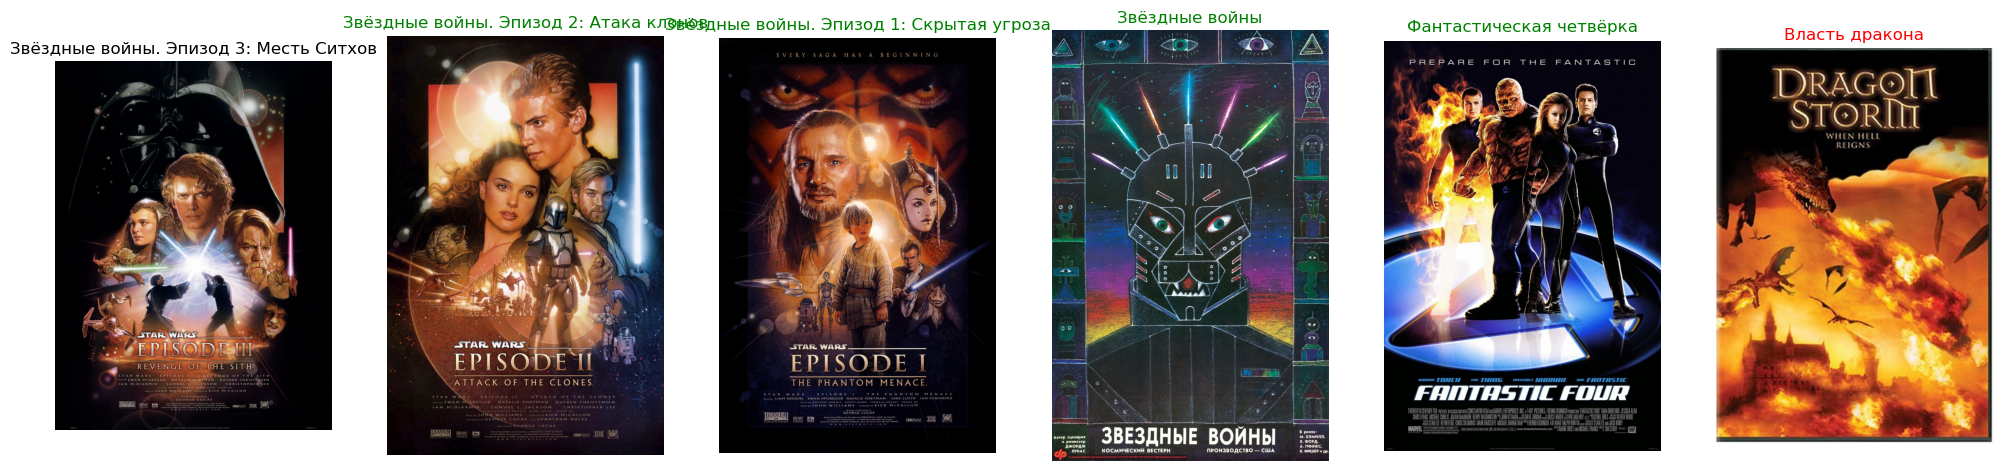

In [56]:
plot_recs(title_id = 'tt0121766', rec_func=get_recommendations_inds, sims=similarities)